# Volatility 評価

### プロジェクトのルートのパスを通す

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリを一括インポート

In [2]:
import math
import os
import re
import statistics
from collections import deque

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.ios import get_excel_sheet
from funcs.technical_backup import MovingRange, CappedTrendAccumulator
from funcs.tide import conv_datetime_from_timestamp

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

## ティックデータの取得

In [4]:
excel = "ticks_20260106.xlsx"
code = "7011"  # 銘柄コード

path_dir = os.path.join("..", "collection")
path_excel = os.path.join(path_dir, excel)
df = get_excel_sheet(path_excel, code)
df

,Time,Price,Volume
0,1.767658e+09,4222,1243800
1,1.767658e+09,4222,1243800
2,1.767658e+09,4222,1393600
3,1.767658e+09,4222,1393600
4,1.767658e+09,4229,1497700
...,...,...,...
19423,1.767681e+09,4248,26822600
19424,1.767681e+09,4248,26822600
19425,1.767681e+09,4248,26825000
19426,1.767681e+09,4248,26825000


In [5]:
df.index = [pd.to_datetime(conv_datetime_from_timestamp(ts)) for ts in df["Time"]]
df

,Time,Price,Volume
2026-01-06 09:00:03,1.767658e+09,4222,1243800
2026-01-06 09:00:04,1.767658e+09,4222,1243800
2026-01-06 09:00:05,1.767658e+09,4222,1393600
2026-01-06 09:00:06,1.767658e+09,4222,1393600
2026-01-06 09:00:07,1.767658e+09,4229,1497700
...,...,...,...
2026-01-06 15:24:45,1.767681e+09,4248,26822600
2026-01-06 15:24:46,1.767681e+09,4248,26822600
2026-01-06 15:24:47,1.767681e+09,4248,26825000
2026-01-06 15:24:48,1.767681e+09,4248,26825000


In [6]:
class Momentum:
    def __init__(self, window_size: int):
        self.window_size = window_size
        self.queue = deque(maxlen=window_size)
        self.momentum: float = 0

    def clear(self):
        self.queue.clear()

    def getValue(self) -> float:
        # 現在値を返す
        return self.momentum

    def update(self, value: float) -> float:
        # 新しい値を追加
        self.queue.append(value)
        if len(self.queue) > 1:
            self.momentum = statistics.variance(self.queue)
        else:
            self.momentum = 0
        # モメンタムを返す
        return self.momentum

In [18]:
class RollingRange:
    def __init__(self, window_size: int):
        self.window_size = window_size
        self.prices = deque(maxlen=window_size)
        self.current_range = 0.0
        self.current_high = None
        self.current_low = None

    def clear(self):
        self.prices.clear()
        self.current_range = 0.0
        self.current_high = None
        self.current_low = None

    def update(self, price: float) -> float:
        self.prices.append(price)

        # high/low を更新
        if self.current_high is None:
            # 初回
            self.current_high = price
            self.current_low = price
        else:
            # 新規値で更新
            self.current_high = max(self.current_high, price)
            self.current_low = min(self.current_low, price)

        # deque が満杯になったとき、古い値が抜けるので high/low を再計算
        if len(self.prices) == self.window_size:
            oldest = self.prices[0]
            if oldest == self.current_high or oldest == self.current_low:
                # high/low が抜けたので再計算
                self.current_high = max(self.prices)
                self.current_low = min(self.prices)

        self.current_range = self.current_high - self.current_low
        return self.current_range

    def getValue(self) -> float:
        return self.current_range


In [19]:
class MonotonicRange:
    def __init__(self, window_size: int):
        self.window_size = window_size
        self.prices = deque()
        self.max_q = deque()  # 単調減少キュー（先頭が最大）
        self.min_q = deque()  # 単調増加キュー（先頭が最小）

    def clear(self):
        self.prices.clear()
        self.max_q.clear()
        self.min_q.clear()

    def update(self, price: float) -> float:
        # 新規価格を追加
        self.prices.append(price)

        # max_q 更新（単調減少）
        while self.max_q and self.max_q[-1] < price:
            self.max_q.pop()
        self.max_q.append(price)

        # min_q 更新（単調増加）
        while self.min_q and self.min_q[-1] > price:
            self.min_q.pop()
        self.min_q.append(price)

        # window サイズを超えたら古い値を削除
        if len(self.prices) > self.window_size:
            old = self.prices.popleft()
            if old == self.max_q[0]:
                self.max_q.popleft()
            if old == self.min_q[0]:
                self.min_q.popleft()

        # レンジ = 最大 - 最小
        return self.max_q[0] - self.min_q[0]

    def getValue(self) -> float:
        if not self.max_q or not self.min_q:
            return 0.0
        return self.max_q[0] - self.min_q[0]


In [32]:
class RollingRangeWithDelta:
    def __init__(self, window_size: int):
        self.range_calc = RollingRange(window_size)
        self.prev_range = None
        self.delta = 0.0

    def clear(self):
        self.range_calc.clear()
        self.prev_range = None
        self.delta = 0.0

    def update(self, price: float):
        current_range = self.range_calc.update(price)

        if self.prev_range is None:
            self.delta = 0.0
        else:
            self.delta = current_range - self.prev_range

        self.prev_range = current_range
        return self.delta

    def getValue(self):
        return self.delta


In [33]:
period = 30
obj_mr = MovingRange(period)
obj_mom = RollingRange(period)
obj_delta = RollingRangeWithDelta(period)

list_mr = list()
for price in df["Price"]:
    list_mr.append(obj_mr.update(price))
df["MR"] = list_mr

list_mom = list()
for price in df["Price"]:
    list_mom.append(obj_mom.update(price))
df["MOM"] = list_mom

list_delta = list()
for price in df["Price"]:
    list_delta.append(obj_delta.update(price))
df["DELTA"] = list_delta

df

,Time,Price,Volume,MR,MOM,DELTA
2026-01-06 09:00:03,1.767658e+09,4222,1243800,0,0,0.0
2026-01-06 09:00:04,1.767658e+09,4222,1243800,0,0,0.0
2026-01-06 09:00:05,1.767658e+09,4222,1393600,0,0,0.0
2026-01-06 09:00:06,1.767658e+09,4222,1393600,0,0,0.0
2026-01-06 09:00:07,1.767658e+09,4229,1497700,7,7,7.0
...,...,...,...,...,...,...
2026-01-06 15:24:45,1.767681e+09,4248,26822600,3,3,0.0
2026-01-06 15:24:46,1.767681e+09,4248,26822600,3,3,0.0
2026-01-06 15:24:47,1.767681e+09,4248,26825000,3,3,0.0
2026-01-06 15:24:48,1.767681e+09,4248,26825000,3,3,0.0


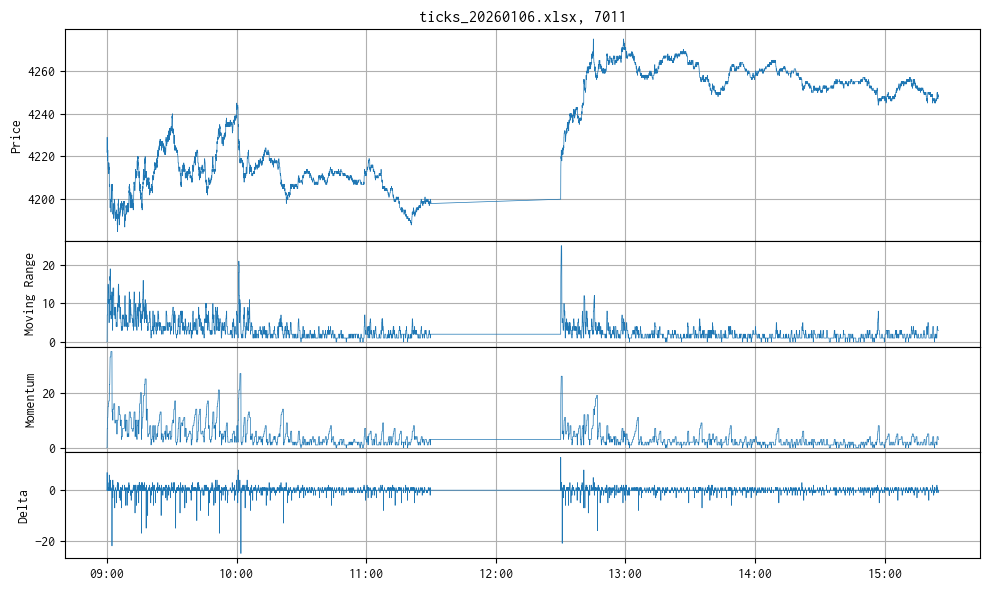

In [34]:
fig = plt.figure(figsize=(10, 6))
n = 4
ax = dict()
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)])
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

ax[0].plot(df["Price"], linewidth=0.5)
ax[0].set_ylabel("Price")

ax[1].plot(df["MR"], linewidth=0.5)
ax[1].set_ylabel("Moving Range")

ax[2].plot(df["MOM"], linewidth=0.5)
ax[2].set_ylabel("Momentum")

ax[3].plot(df["DELTA"], linewidth=0.5)
ax[3].set_ylabel("Delta")

plt.tight_layout()
output = os.path.join("..", "tmp", "mr_test.png")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].set_title(f"{excel}, {code}")
plt.tight_layout()
plt.savefig(output)
plt.show()